<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC1_2020_NB_LogisticRegressionPCAtSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Regressione Logistica e Ricerca di Particelle Supersimmetriche #


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Informazioni

scopo: imparare a risolvere un problema di classificazioen tramite un classificatore lineare di regressione logistica, prendere dimestichezza con la libreria scikit-learn e imparare l'uso del package Pandas per la gestione di dataset complessi

campione di esempi: [SUSY dataset](https://archive.ics.uci.edu/ml/datasets/SUSY) da [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

Ci focalizzermeo in una task di classificazione binaria (segnale (SUSY) - fondo (processi del Modello Standard con stessi stati finali di quelli prodotti nei decadimenti delle particelle supersimmetriche)).


**Regressione logistica**

È una dei modelli classici del ML per la classificazione che permette di introdurre la maggior parte delle idee e techniche del ML supervisionato. 

Ogni set di fatures $\mathbf{x}_i$ è associato ad una label di categoria (classe)$C_i\in\{1,0\}$, con $i=1\ldots n$.
Di seguito il feature vector $\mathbf{x}_i$ è ridefinito via the augmented rapresentation $\mathbf{x}\rightarrow (1,\mathbf{x})$. 
La likelihood function della regressione logistica è data dalla funzione sigmoide:

$$
P(c_i=1)=1-P(c_i=0)= {1 \over 1+ e^{-\mathbf{w}\cdot \mathbf{x}_i}},
$$

in cui $\mathbf{w}$ sono i pesi che definiscono il modello di regressione logistica e che vengono scelti massimizzando la log-likelihood sul campione di dati di training. 

Definendo la funzione:
$$
f(a)={1 \over 1+ e^{-a}},
$$

con derivata rispetto a $a$:
$$
{df \over da}= f(1-f).
$$

e definendo $f_i \equiv f(\mathbf{w}\cdot \mathbf{x}_i)$, possiamo esprimere la likelihood dei dati $\{ \mathbf{x}_i, C_i \}$ come:

$$
P(Data|\mathbf{x})= \prod_{i=1}^n f_i^{C_i}(1-f_i)^{1-C_i}
$$

con log-likelihood:
$$
\log{P(Data|\mathbf{w})}= \sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i)
$$

La log-likelihood cambiata di segno fornisce la loss function ed è chiamata cross-entropy error function:
$$
\mathrm{Cross\,Entropy}=E(\mathbf{w})= -\sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i).
$$

Osserviamo che:
$$
\nabla E(\mathbf{w})=\sum_{i=1}^n (f_i-C_i)\mathbf{x}_i.
$$

cioè il gradiente punta nella direzione della somma delle direzioni dei vettori del training set pesata con la differenza tra la label vera e la probabilità di predire la label stessa.

La stima di massima verosimiglianza (MLE) corrisponde alla minimizzazione della cross-entropia. Questo può essere fatto usando metodi di discesa lungo il gradiente.

### Passo 1: carica il dataset con pandas

**informazioni sul dataset:**

>Provide all relevant informatioThe data has been produced using Monte Carlo simulations. The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes.

* data format: The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features):: lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1). For detailed information about each feature see the original paper.


* reference: <cite> P. Baldi, P. Sadowski, and D. Whiteson. "Searching for Exotic Particles in High-energy Physics with Deep Learning." Nature Communications 5 (July 2, 2014)</cite>.

Il campione che potete scaricare da qui [Campione SUSY.csv 1M eventi](https://www.dropbox.com/s/qfvjlrdz38goien/SUSY.csv?dl=0) contiene solo 1M degli 11M di eventi del dataset totale (per mantenere la size limitata).

Importiamo il dataset cono pandas usando i primi 950k eventi come training set e i secondi 50k come test set.

In [0]:
# Importing the SUSY Data set
import sys, os
import pandas as pd

import numpy as np
import warnings

#warnings.filterwarnings('ignore') #se non si vogliono ricevere warning scommentare questa riga


seed=12345
np.random.seed(seed)

# Download SUSY.csv 
filename="/content/drive/My Drive/Colab Notebooks/datasets/SUSY.csv"
#filename=sample_data/SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 950k rows as train data, 50k as test data
df = pd.read_csv(filename, names=columns, nrows=1000000, engine='python')
df_train=pd.read_csv(filename,names=columns,nrows=950000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=950000,engine='python')

**Definizione funzioni utili in pandas:**

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

#accede in pandas ai dati del campione di training e li formatta in modo comodo
def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_train['signal'].values # labels (0 or 1)
    return (designMatrix,labels)

#accede in pandas ai dati del campione di test e li formatta in modo comodo 
def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_test['signal'].values
    return (designMatrix,labels)

# usa pandas per costruire curve pseudo-ROC
def build_roc_curve(probs, signal_bit, threshes):
    # Convert things to a pandas series to build a DataFrame
    # which will make ROC curve logic easier to express
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        # define acceptance
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        # sum over data frame with slicing conditions
        nSigCor = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection

### Passo 2:  Training  del modello lineare tipo logistic regression con scikit-learn

**definizione dei modelli:**

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

#logistic discriminant con regolarizzazione L2
def runSciKitRegressionL2(nVar, alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log", penalty="l2",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs, Acceptance, Rejection)

#logistic discriminant con regolarizzazione L1
def runSciKitRegressionL1(nVar,alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log", penalty="l1",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs,Acceptance,Rejection)

**Training e valutazione del modello con regolarizzazione L1**

* usiamo inizialmente solo le prime 8 feature (low-level)
* $\alpha$ parametro che definisce il peso del termine di regolarizzazione e che va scelto in modo da missimizzare le prestazioni


Accuracy on test data with alpha 1.00E-10 : 0.699
Accuracy on test data with alpha 1.26E-09 : 0.692
Accuracy on test data with alpha 1.58E-08 : 0.713
Accuracy on test data with alpha 2.00E-07 : 0.756
Accuracy on test data with alpha 2.51E-06 : 0.722
Accuracy on test data with alpha 3.16E-05 : 0.768
Accuracy on test data with alpha 3.98E-04 : 0.769
Accuracy on test data with alpha 5.01E-03 : 0.768
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.542


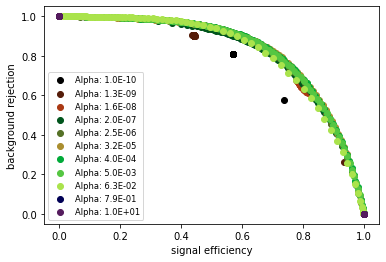

In [0]:
plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(8,alpha) #L1 or L2
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

**Osservazioni:**

abbiamo ottenuto un accuracy del 77% che è già piuttosto buona per un'analisi di questo tipo. Tramite la curva pseudo-ROC il fisico delle particelle può decidere il punto ottimale di lavoro per la data analisi (i.e. la condizione efficienza segnale vs reieizione fondo che ottimizza per esempio la sensibilità di scoperta).

Notiamo anche che i risultati sono sensibili al peso della regolarizzazione $\alpha$. In particolare i risultati delle punti della curva a peggiori prestazioni (verde scuro) indicano che in questi casi il modello non è in grado di distinguere tra le due classi. 

Ci aspettiamo che questo succeda per valori di $\alpha$ più grandi, perchè la regolarizzazione L1 effttivamente tende a "spegnere" la maggior parte delle osservabili (costringe i pesi ad essere vicini a zero), di conseguenza la classificazione risulta in effetti nel tracciare una superficie nella distribuzione di pochissime (probabilmente una sola) fetaure in input, classificando gli eventi di segnale quelli da una pate della superficie e di fondo quelli dall'altra.

Per verificarlo plottiamo la probabilità di segnale e fondo ricostruite dal modello per il caso di $\alpha$ ottimale ($\alpha = 3.98E-04$) e per il caso peggiore ($\alpha = 0.79$):

Accuracy on test data with alpha 3.98E-04 : 0.769


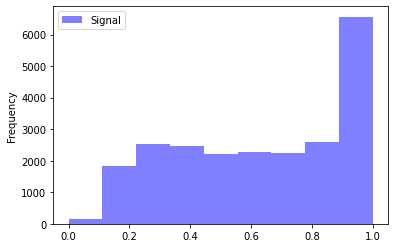

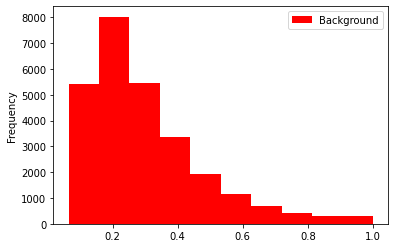

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,3.98e-4) #L1 or L2
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 7.94E-01 : 0.542


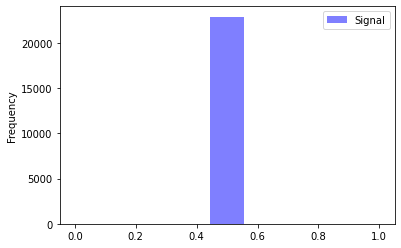

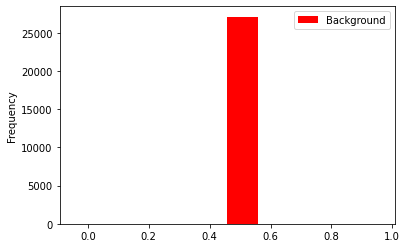

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,7.94e-1) #L1 or L2
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

### Ottimizziamo ora usando tutte e 18 le osservabili ... ###

Accuracy on test data with alpha 1.00E-10 : 0.632
Accuracy on test data with alpha 1.26E-09 : 0.617
Accuracy on test data with alpha 1.58E-08 : 0.675
Accuracy on test data with alpha 2.00E-07 : 0.751
Accuracy on test data with alpha 2.51E-06 : 0.754
Accuracy on test data with alpha 3.16E-05 : 0.789
Accuracy on test data with alpha 3.98E-04 : 0.789
Accuracy on test data with alpha 5.01E-03 : 0.785
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


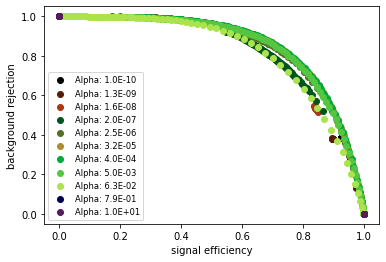

In [0]:
plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha) #L1 or L2
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.787


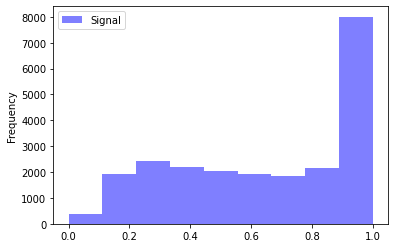

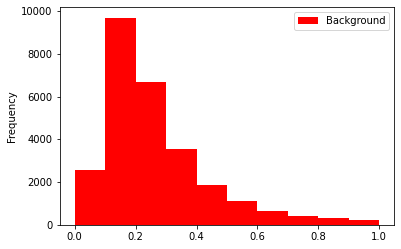

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(18,3.98e-4) #L1 or L2
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

abbiamo migliorato l'accuracy che ora è del 79% e, come atteso dall'usare più features, è diminuita la dipedenza dalla regolarizzazione...

<b> Esercizi:</b>

* provare ad usare la regolarizzazione L2, i risultati migliorano?

* provare a addestrare il modello dopo aver normalizzato i dati in input in modo che abbiano simile dinamica, i risultati cambiano? 

* provare ad usare dei tagli rettangolari sulle osservabili migliori, calcolate le prestaizoni in termini di efficienza e reiezione e confrontate con la ROC curva ottenuta con la regressione logistica ... 

* provate a pensare se sia possibile selezionare una regione del campione dei dati di training che permetta di migliorare le prestazioni (suggerimento: pensare a dove il guadagano dall'uso del ML ha più valore rispetto ad una analisi tradizionale cut-based).

# **Confronto con la regolarizzazione L2**

Operiamo anzitutto una regressione logistica con regolarizzazione L2, in modo da confrontoare i risultati con quelli ottenuti con la L1. Occupiamoci dapprima del caso low-level.

Accuracy on test data with alpha 1.00E-10 : 0.641
Accuracy on test data with alpha 1.26E-09 : 0.645
Accuracy on test data with alpha 1.58E-08 : 0.670
Accuracy on test data with alpha 2.00E-07 : 0.691
Accuracy on test data with alpha 2.51E-06 : 0.732
Accuracy on test data with alpha 3.16E-05 : 0.764
Accuracy on test data with alpha 3.98E-04 : 0.768
Accuracy on test data with alpha 5.01E-03 : 0.769
Accuracy on test data with alpha 6.31E-02 : 0.758
Accuracy on test data with alpha 7.94E-01 : 0.692
Accuracy on test data with alpha 1.00E+01 : 0.458


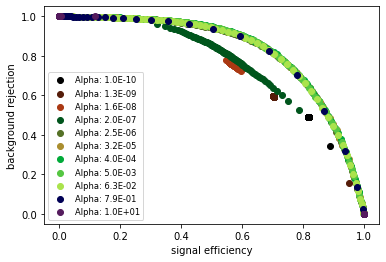

In [0]:
#regressione low-level con regolarizzazione L2

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(8,alpha) #L1 or L2
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 5.01E-03 : 0.768


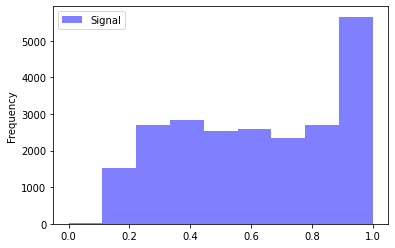

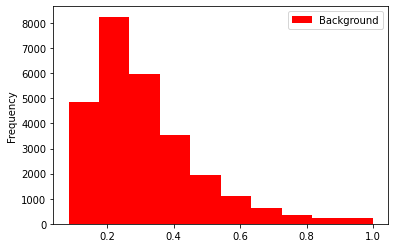

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(8,5.01e-3) #L1 or L2
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E-10 : 0.651


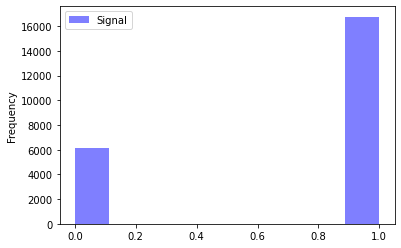

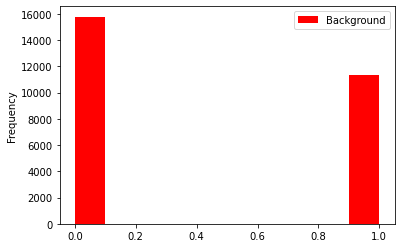

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(8,1.00e-10) #L1 or L2
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

L'accuracy migliore risulta associata ad $\alpha=5.01\text{ }E\text{ }-3$ ed è pressocché invariata rispetto al valore ottenuto con la regolarizzazione L1 (l'accuracy risulta infatti 0.768 e si osserva dunque un calo solo dello 0.1%). Neanche nel caso della scelta peggiore per il parametro si ottiene un miglioramento: per $\alpha=10^{-10}$ infatti, gli istogrammi delle distribuzioni di probabilità non permettono ancora una distinzione tra rumore e segnale.

Passiamo ora ad una regressione su tutte le 18 feature con la regolarizzazione L2.

Accuracy on test data with alpha 1.00E-10 : 0.705
Accuracy on test data with alpha 1.26E-09 : 0.594
Accuracy on test data with alpha 1.58E-08 : 0.730
Accuracy on test data with alpha 2.00E-07 : 0.679
Accuracy on test data with alpha 2.51E-06 : 0.749
Accuracy on test data with alpha 3.16E-05 : 0.787
Accuracy on test data with alpha 3.98E-04 : 0.790
Accuracy on test data with alpha 5.01E-03 : 0.785
Accuracy on test data with alpha 6.31E-02 : 0.761
Accuracy on test data with alpha 7.94E-01 : 0.718
Accuracy on test data with alpha 1.00E+01 : 0.458


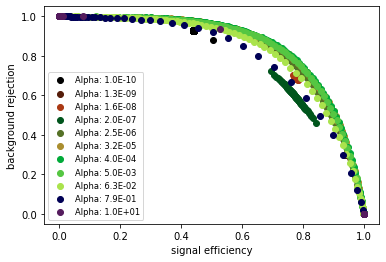

In [0]:
#regressione sulle 18 feature con regolarizzazione L2

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(18,alpha) #L1 or L2
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.789


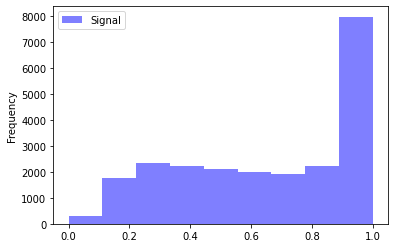

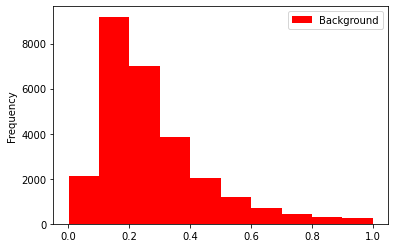

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(18,3.98e-4) #L1 or L2
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Non notiamo una grande differenza tra i risultati ottenuti con i due diversi tipi di regolarizzazione. Entrambe presentano l'accuracy massima per $\alpha=3.98\text{ }E\text{ }-4$ e la variazione tra i due valori è dello 0.3% (si passa da un'accuracy pari a 0.787 con regolarizzazione L1 a 0.790 con regolarizzazione L2).

# **Regressione con dati normalizzati**

Intendiamo ora studiare l'effetto di una normalizzazione dei dati, in modo che le misure di ciascuna osservabile siano comprese tra 0 e 1 e la somma delle misure ottenute per ciascuna osservabile sia 1. Valutiamo l'effetto di tale trasformazione dei dati sulla regressione sia utilizzando la regolarizzazione L1, sia la L2.

In [0]:
#normalizziamo il dataframe in modo che ogni osservabile presenti misure comprese tra 0 e 1
from sklearn import preprocessing

# Download SUSY.csv 
filename="/content/drive/My Drive/Colab Notebooks/datasets/SUSY.csv"
df_train=pd.read_csv(filename,names=columns,nrows=950000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=950000,engine='python')

scaler = preprocessing.MinMaxScaler()
df_train[["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]] = scaler.fit_transform(df_train[["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]])
df_test[["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]] = scaler.fit_transform(df_test[["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]])

Accuracy on test data with alpha 1.00E-10 : 0.601
Accuracy on test data with alpha 1.26E-09 : 0.697
Accuracy on test data with alpha 1.58E-08 : 0.755
Accuracy on test data with alpha 2.00E-07 : 0.672
Accuracy on test data with alpha 2.51E-06 : 0.696
Accuracy on test data with alpha 3.16E-05 : 0.710
Accuracy on test data with alpha 3.98E-04 : 0.697
Accuracy on test data with alpha 5.01E-03 : 0.755
Accuracy on test data with alpha 6.31E-02 : 0.542
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.542


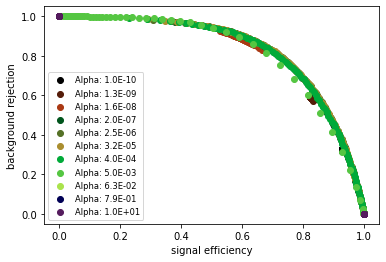

In [0]:
#operiamo una regressione low-level con regolarizzazione L1

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 5.01E-03 : 0.755


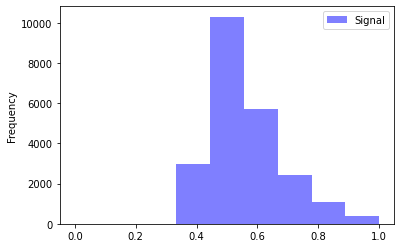

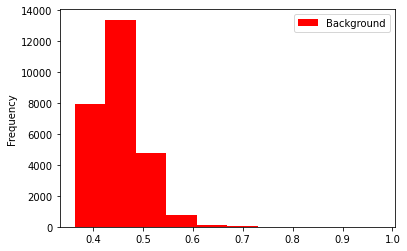

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8, 5.01e-3 )
Signal = df_test.iloc[:,0:1]

nor_df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
nor_df_test_acc['SIG']=Signal
nor_df_test_acc_sig = nor_df_test_acc.query('SIG==1')
nor_df_test_acc_bkg = nor_df_test_acc.query('SIG==0')
nor_df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
nor_df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 7.94E-01 : 0.542


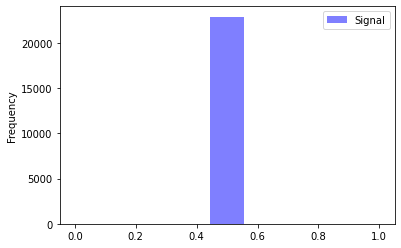

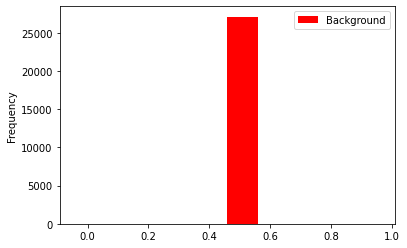

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,7.94e-1)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

La regressione low-level con regolarizzazione L1 su dati normalizzati fornisce risultati peggiori rispetto al caso precedentemente analizzato. L'accuracy migliore è ora del 75.5% e anche gli istogrammi delle distribuzioni di probabilità sembrano meno abili nel distinguere tra segnale e rumore.

Passiamo alla regressione sulle 18 feature e regolarizzazione L1.

Accuracy on test data with alpha 1.00E-10 : 0.770
Accuracy on test data with alpha 1.26E-09 : 0.781
Accuracy on test data with alpha 1.58E-08 : 0.655
Accuracy on test data with alpha 2.00E-07 : 0.762
Accuracy on test data with alpha 2.51E-06 : 0.785
Accuracy on test data with alpha 3.16E-05 : 0.776
Accuracy on test data with alpha 3.98E-04 : 0.779
Accuracy on test data with alpha 5.01E-03 : 0.693
Accuracy on test data with alpha 6.31E-02 : 0.542
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


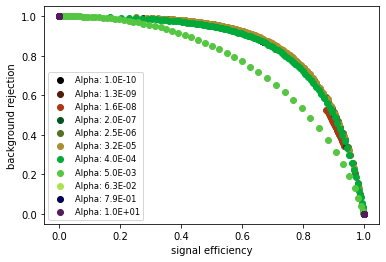

In [0]:
#operiamo una regressione con tutte le 18 feature con regolarizzazione L1

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 2.51E-06 : 0.783


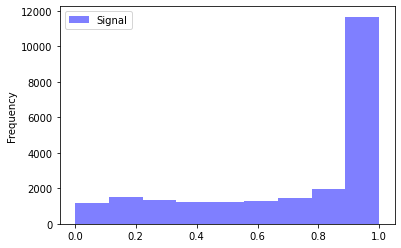

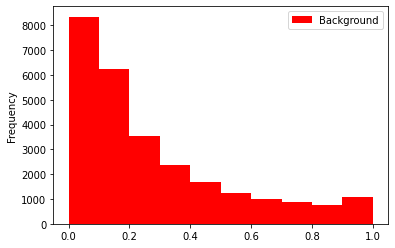

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(18,2.51e-6) #L1 or L2
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Anche la regressione sulle 18 feature non presenta segni di miglioramento rispetto all'analisi condotta sui dati non normalizzati. Sebbene gli istogrammi sembrino indicare una maggiore capacità nell'individuazione del segnale, la relativa costanza dell'accuracy induce a pensare più a delle fluttuazione, che a degli effettivi miglioramenti.

Proseguiamo con l'analisi della regolarizzazione L2. Partiamo dal caso low-level.

Accuracy on test data with alpha 1.00E-10 : 0.723
Accuracy on test data with alpha 1.26E-09 : 0.581
Accuracy on test data with alpha 1.58E-08 : 0.665
Accuracy on test data with alpha 2.00E-07 : 0.585
Accuracy on test data with alpha 2.51E-06 : 0.699
Accuracy on test data with alpha 3.16E-05 : 0.700
Accuracy on test data with alpha 3.98E-04 : 0.733
Accuracy on test data with alpha 5.01E-03 : 0.716
Accuracy on test data with alpha 6.31E-02 : 0.542
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


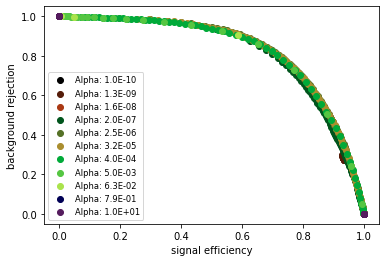

In [0]:
#regressione low-level con dati normalizzati e regolarizzazione L2

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.749


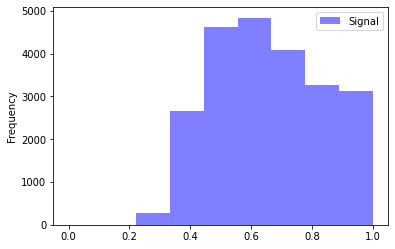

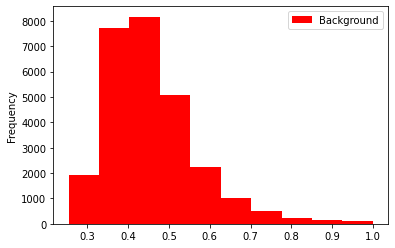

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(8,3.98e-4)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 7.94E-01 : 0.697


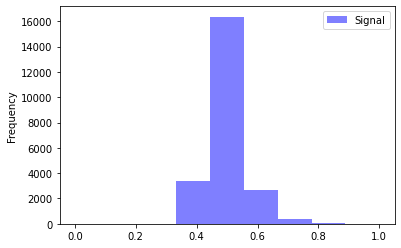

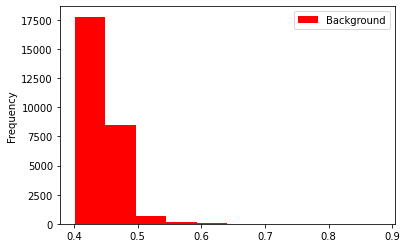

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(8,7.94e-1)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Anche con la regolarizzazione L2 la regressione low-level perde qualità. I risultati sono analoghi a quelli ottenuti con la corrispettiva regressione con regolarizzazione L1.

Infine, passiamo alla regressione sulle 18 feature anche con la regolarizzazione L2.

Accuracy on test data with alpha 1.00E-10 : 0.650
Accuracy on test data with alpha 1.26E-09 : 0.766
Accuracy on test data with alpha 1.58E-08 : 0.688
Accuracy on test data with alpha 2.00E-07 : 0.766
Accuracy on test data with alpha 2.51E-06 : 0.779
Accuracy on test data with alpha 3.16E-05 : 0.772
Accuracy on test data with alpha 3.98E-04 : 0.753
Accuracy on test data with alpha 5.01E-03 : 0.702
Accuracy on test data with alpha 6.31E-02 : 0.609
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


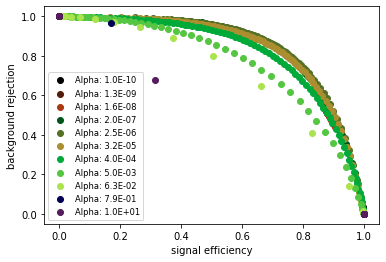

In [0]:
#regressione a 18 feature con dati normalizzati e regolarizzazione L2

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 2.51E-06 : 0.778


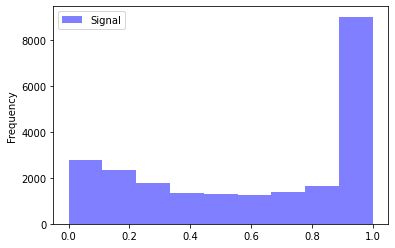

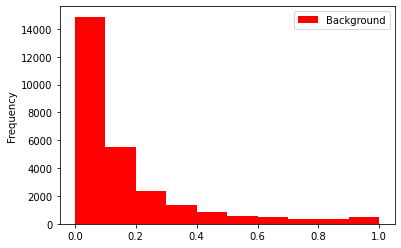

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(18,2.51e-6)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

I risulati sono di qualità inferiore al caso di dati non normalizzati, seppure solo leggermente. Visto il nuovo valore dell'accuracy ($\simeq 78\%$, prossimo al 79% ottenuto con i dati non normalizzati) e l'andamento degli istogrammi (coerente con quello riscontrato con i dati non normalizzati), è ancora opportuno attribuire la variazione dei risultati a delle fluttuazioni.

#**Regressione con dati standardizzati**

Riproponiamo ora gli stessi studi operati in precedenza, utilizzando ora dei dati standardizzati: riscaliamo ciascuna osservabile in modo che le misure ottenute abbiano media nulla e varianza unitaria e tentiamo di capire se tale operazione porti vantaggi in termini di accuracy.

Partiamo con regressioni con regolarizzazioni L1, sia low-level, sia sulle 18 feature.

In [0]:
#standardizziamo il data frame, in modo che ogni osservabile abbia media nulla e varianza unitaria

from sklearn.preprocessing import StandardScaler

# Download SUSY.csv 
filename="/content/drive/My Drive/Colab Notebooks/datasets/SUSY.csv"
df_train=pd.read_csv(filename,names=columns,nrows=950000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=950000,engine='python')
df = pd.read_csv(filename, names=columns, nrows=1000000, engine='python')

names = df.columns
#std_df = df.copy()
df_train[['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']] = StandardScaler().fit_transform(df_train[['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']])
df_test[['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']] = StandardScaler().fit_transform(df_test[['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']])
#std_df[['signal']] = df[['signal']]
#std_df = pd.DataFrame(std_df, columns = names)
#print(std_df)
#std_df_train = std_df[:950000]
#std_df_test = std_df[950000:]


Accuracy on test data with alpha 1.00E-10 : 0.731
Accuracy on test data with alpha 1.26E-09 : 0.615
Accuracy on test data with alpha 1.58E-08 : 0.624
Accuracy on test data with alpha 2.00E-07 : 0.536
Accuracy on test data with alpha 2.51E-06 : 0.763
Accuracy on test data with alpha 3.16E-05 : 0.768
Accuracy on test data with alpha 3.98E-04 : 0.768
Accuracy on test data with alpha 5.01E-03 : 0.769
Accuracy on test data with alpha 6.31E-02 : 0.758
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.542


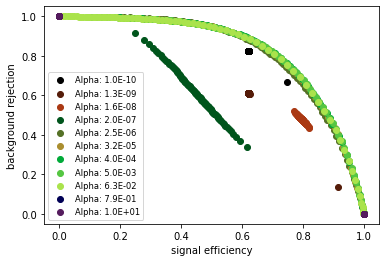

In [0]:
#operiamo una regressione low-level con regolarizzazione L1

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 5.01E-03 : 0.768


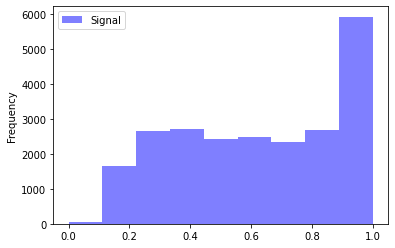

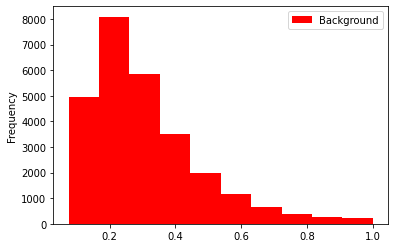

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,5.01e-3)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E+01 : 0.458


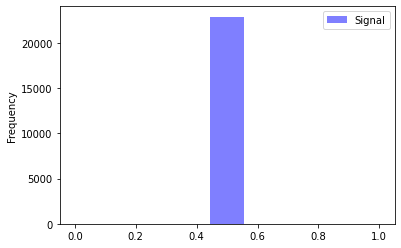

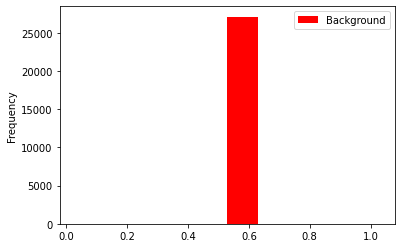

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,1.00e-10)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E-10 : 0.535
Accuracy on test data with alpha 1.26E-09 : 0.762
Accuracy on test data with alpha 1.58E-08 : 0.679
Accuracy on test data with alpha 2.00E-07 : 0.775
Accuracy on test data with alpha 2.51E-06 : 0.782
Accuracy on test data with alpha 3.16E-05 : 0.789
Accuracy on test data with alpha 3.98E-04 : 0.790
Accuracy on test data with alpha 5.01E-03 : 0.788
Accuracy on test data with alpha 6.31E-02 : 0.758
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


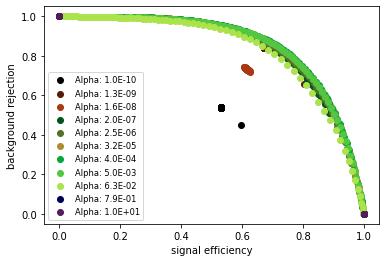

In [0]:
#operiamo una regressione su 18 feature con regolarizzazione L1

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.789


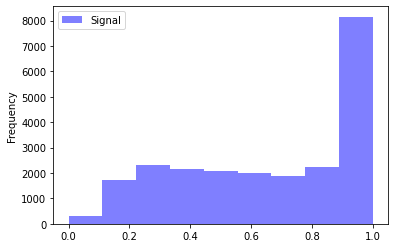

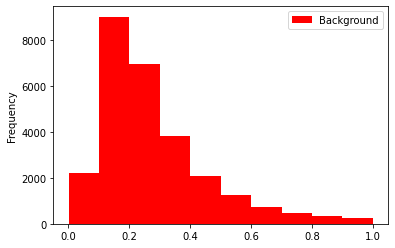

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(18,3.98e-4)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

I risultati ottenuti in questa fase sono analoghi a quelli relativi ai dati non standardizzati, con delle minime fluttuazioni. I valori delle accuracy tendono a coincidere, così come gli andamenti degli istogrammi.

Ripetiamo gli studi con la regolarizzazione L2.

Accuracy on test data with alpha 1.00E-10 : 0.632
Accuracy on test data with alpha 1.26E-09 : 0.670
Accuracy on test data with alpha 1.58E-08 : 0.640
Accuracy on test data with alpha 2.00E-07 : 0.705
Accuracy on test data with alpha 2.51E-06 : 0.744
Accuracy on test data with alpha 3.16E-05 : 0.768
Accuracy on test data with alpha 3.98E-04 : 0.768
Accuracy on test data with alpha 5.01E-03 : 0.769
Accuracy on test data with alpha 6.31E-02 : 0.761
Accuracy on test data with alpha 7.94E-01 : 0.704
Accuracy on test data with alpha 1.00E+01 : 0.543


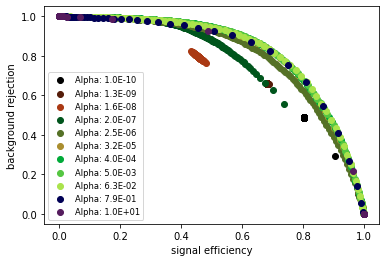

In [0]:
#operiamo una regressione low-level con regolarizzazione L2

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.769


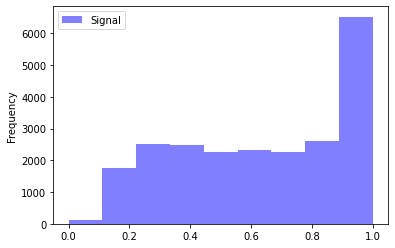

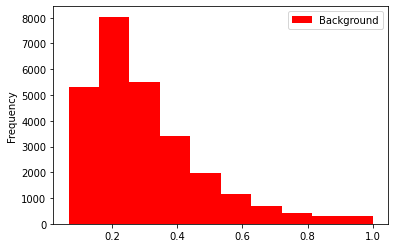

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(8,3.98e-4)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E+01 : 0.544


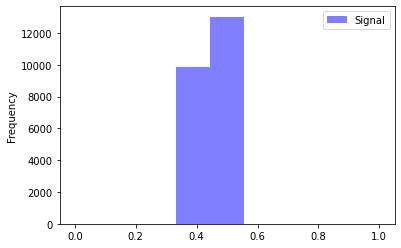

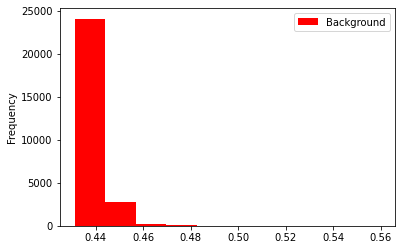

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(8,1.00e-10)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E-10 : 0.728
Accuracy on test data with alpha 1.26E-09 : 0.761
Accuracy on test data with alpha 1.58E-08 : 0.676
Accuracy on test data with alpha 2.00E-07 : 0.701
Accuracy on test data with alpha 2.51E-06 : 0.754
Accuracy on test data with alpha 3.16E-05 : 0.788
Accuracy on test data with alpha 3.98E-04 : 0.790
Accuracy on test data with alpha 5.01E-03 : 0.787
Accuracy on test data with alpha 6.31E-02 : 0.768
Accuracy on test data with alpha 7.94E-01 : 0.735
Accuracy on test data with alpha 1.00E+01 : 0.458


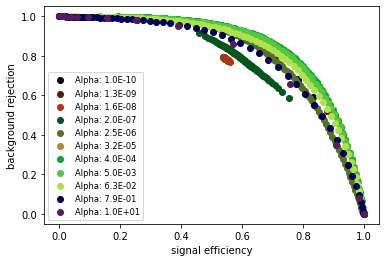

In [0]:
#operiamo una regressione su 18 feature con regolarizzazione L2

plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.790


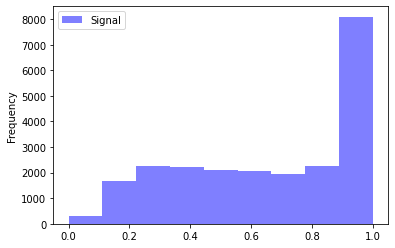

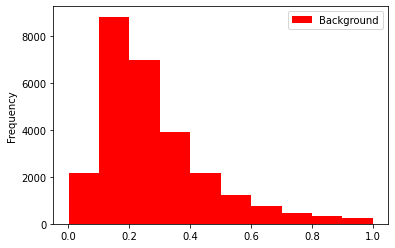

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(18,3.98e-4)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Anche in questo caso si riottengono risultati compatibili con quelli già ricavati senza standardizzare i dati.

#**Applicazione di PCA a SUSY**

Proviamo ad applicare l'algoritmo di riduzione dimensionale PCA al dataset di SUSY. Opereremo una riduzione a 3 componenti.

In [0]:
from sklearn.decomposition import PCA

# Importing the SUSY Data set
import sys, os
import pandas as pd

import numpy as np
import warnings

#warnings.filterwarnings('ignore') #se non si vogliono ricevere warning scommentare questa riga


seed=12345
np.random.seed(seed)

# Download SUSY.csv 
filename="/content/drive/My Drive/Colab Notebooks/datasets/SUSY.csv"
#filename=sample_data/SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 950k rows as train data, 50k as test data
df = pd.read_csv(filename, names=columns, nrows=10000, engine='python')
#df_train=pd.read_csv(filename,names=columns,nrows=950000,engine='python')
#df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=950000,engine='python')

rnd = np.random.permutation(df.shape[0])

pca = PCA(n_components=3)
pca_used = df.loc[rnd[:10000],:].copy()
pca_df =pca_used.copy()
pca_df = pca_df.drop(['signal'], axis=1)

pca_result = pca.fit_transform(pca_df.values)

pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1]
pca_df['pca-three'] = pca_result[:,2]

print('Explained variation for principal component = {}'.format(pca.explained_variance_ratio_))

pca_df['signal'] = pca_used['signal']

Explained variation for principal component = [0.21387623 0.14724111 0.12447848]


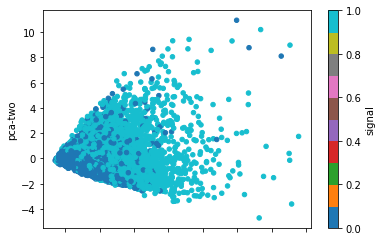

In [0]:
#grafichiamo le prime due componenti

rndperm = np.random.permutation(pca_df.shape[0])
ax = pca_df.loc[:,:].plot.scatter(x='pca-one', y='pca-two', c='signal', colormap='tab10')

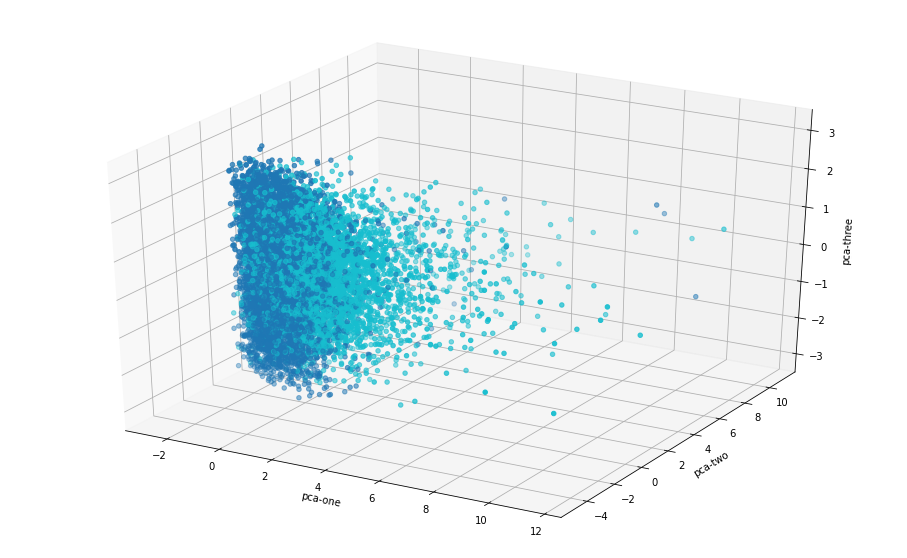

In [0]:
#3d usando matplotlib ...
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_df.loc[rndperm,:]["pca-one"], 
    ys=pca_df.loc[rndperm,:]["pca-two"], 
    zs=pca_df.loc[rndperm,:]["pca-three"], 
    c=pca_df.loc[rndperm,:]["signal"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

La rappresentazione grafica dei dati elaborati dall'algoritmo (sia nel caso bidimensionale, sia in quello tridimensionale) rivela una lieve separazione tra segnale e rumore, sebbene questa non sia ancora sufficientemente precisa.

#**Applicazione di tSNE a SUSY**

Applichiamo ora l'algoritmo tSNE a SUSY, utilizzando 2 componenti.



In [0]:
#proviamo a farlo per bene, escludendo il segnale

from sklearn.manifold import TSNE
import time

rnd = np.random.permutation(df.shape[0])
df_used = df.loc[rnd[:10000], :].copy()
df_subset = df_used.copy()
df_subset.drop(['signal'], axis=1)
data = df_subset.values
start_time = time.time()
tsne = TSNE(n_components=2, init='pca', verbose=3, perplexity=60, n_iter=1000)
tsne_results = tsne.fit_transform(data)
print(f'elapsed time = {time.time()-start_time}')


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.039s...
[t-SNE] Computed neighbors for 10000 samples in 4.581s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.848124
[t-SNE] Computed conditional probabilities in 0.999s
[t-SNE] Iteration 50: error = 85.5411301, gradient norm = 0.0005385 (50 iterations in 5.580s)
[t-SNE] I

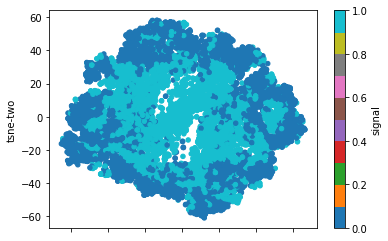

In [0]:
df_subset['tsne-one'] = tsne_results[:, 0]
df_subset['tsne-two'] = tsne_results[:, 1]
df_subset['signal'] = df_used['signal']

import matplotlib.pyplot as plt

ax = df_subset.loc[:,:].plot.scatter(x='tsne-one', y='tsne-two', c='signal', colormap='tab10')

In questo caso, l'algoritmo raggruppa i dati corrispondenti al segnale al centro del grafico, circondati dai dati relativi al rumore. Anche in questo caso, però, la separazione non appare abbastanza netta. In ogni caso, il valore della divergenza KL, che dovrebbe tendere a 0, è molto basso (2.12) già dopo un numero esiguo di iterazioni, nonostante si sia utilizzato un numero piccolo di componenti per la tSNE. QUesto è segno della funzionalità dell'algoritmo nel caso in esame.

#**Applicazione congiunta di PCA e tSNE su SUSY**

Proviamo ora ad utilizzare l'algoritmo tSNE su dei dati precedentemente trattati con PCA. Opereremo una PCA a 10 componenti e una tSNE a 2 componenti.

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import time
seed=12345

# Download SUSY.csv 
filename="/content/drive/My Drive/Colab Notebooks/datasets/SUSY.csv"
#filename=sample_data/SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 10k rows as train data
df=pd.read_csv(filename,names=columns,nrows=10000,engine='python')

In [0]:
np.random.seed(seed)
rndperm = np.random.permutation(df.shape[0])

# selezioniamo i primi 10k eventi dal dataframe 
N = 50000
df_subset = df.loc[rndperm[:N],:].copy()
df_copy=df_subset
df_subset = df_subset.drop(columns= 'signal')
columns=["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

data_subset = df_subset.values

pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(data_subset)
print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result_10)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Cumulative explained variation for 10 principal components: 0.9603858433369988
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.019s...
[t-SNE] Computed neighbors for 10000 samples in 2.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.791237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.166443

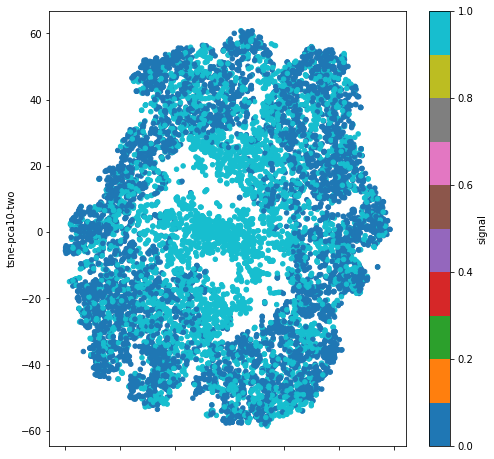

In [0]:
df_subset['tsne-pca10-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca10-two'] = tsne_pca_results[:,1]
df_subset['signal'] = df_copy['signal']
ax4=df_subset.plot.scatter(x="tsne-pca10-one", y="tsne-pca10-two", c='signal', colormap='tab10',figsize=(8,8))

La tendenza del grafico è compatibile con quella associata all'applicazione di tSNE sul dataset completo.

# **Tagli rettangolari**

Intendiamo ora operare dei tagli rettangolari sulle variabili migliori. Ricerchiamo anzitutto le variabili che garantiscono da sole l'accuracy migliore in tal senso.



In [0]:
#test variabili singole (selezione di quelle che singolarmente forniscon migliore accuracy con un singolo taglio fisso sulla variabile)

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]
variabili =["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]
df_train=pd.read_csv(filename,names=columns,nrows=950000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=950000,engine='python')

nstep = 20
ALL = df_train['signal'].count()
for nome in variabili:
    print('Variable: ', nome)
    vmax = df_train[nome].max()
    vmin = df_train[nome].min()
    #print('min / max: %f / %f' %(vmin, vmax))
    delta = (vmax-vmin)/nstep
    acc_gt_max = -9999.
    cut_gt_max = -9999.
    acc_lt_max = -9999.
    cut_lt_max = -9999.
    for i in range(nstep):
        cut = vmin + delta*i
        data_sel_gt = df_train.loc[df_train[nome] >= cut]
        data_sel_lt = df_train.loc[df_train[nome] < cut]
        TP_gt = (data_sel_gt['signal'].loc[data_sel_gt['signal'] > 0.5]).count()
        TN_gt = (data_sel_lt['signal'].loc[data_sel_lt['signal'] < 0.5]).count()
        TP_lt = (data_sel_lt['signal'].loc[data_sel_lt['signal'] > 0.5]).count()
        TN_lt = (data_sel_gt['signal'].loc[data_sel_gt['signal'] < 0.5]).count()
        acc_gt = (TP_gt + TN_gt)/ALL
        acc_lt = (TP_lt + TN_lt)/ALL
        if acc_gt >= acc_gt_max:
           acc_gt_max = acc_gt
           cut_gt_max = cut
        if acc_lt >= acc_lt_max:
           acc_lt_max = acc_lt
           cut_lt_max = cut   
    if (acc_gt_max >= acc_lt_max):
        print('best cut is gt: >%f / accuracy %f' %(cut_gt_max, acc_gt_max))
    else:
        print('best cut is lt: <%f / accuracy %f' %(cut_lt_max, acc_lt_max))        

Variable:  lepton 1 pT
best cut is gt: >1.240213 / accuracy 0.678025
Variable:  lepton 1 eta
best cut is lt: <-2.102919 / accuracy 0.542066
Variable:  lepton 1 phi
best cut is lt: <-1.734789 / accuracy 0.542066
Variable:  lepton 2 pT
best cut is gt: >1.712696 / accuracy 0.580512
Variable:  lepton 2 eta
best cut is lt: <-2.059306 / accuracy 0.542066
Variable:  lepton 2 phi
best cut is lt: <-1.734202 / accuracy 0.542066
Variable:  missing energy magnitude
best cut is gt: >0.961009 / accuracy 0.721126
Variable:  missing energy phi
best cut is lt: <-1.727112 / accuracy 0.542066
Variable:  MET_rel
best cut is gt: >1.924238 / accuracy 0.624680
Variable:  axial MET
best cut is gt: >1.436781 / accuracy 0.599152
Variable:  M_R
best cut is gt: >1.163800 / accuracy 0.630276
Variable:  M_TR_2
best cut is gt: >0.815813 / accuracy 0.669620
Variable:  R
best cut is gt: >1.354843 / accuracy 0.552324
Variable:  MT2
best cut is gt: >1.930730 / accuracy 0.582987
Variable:  S_R
best cut is gt: >0.937375 /

Le variabili migliori sulle quali effettuare i tagli sono *lepton 1 pT* e *missing energy magnitude*. Selezioniamo ora i tagli che forniscono la miglior accuracy sulle due variabili selezionate.

In [0]:
#seleziona best cut rettangolare combinato sulle due variabili

nstep = 20 #nota è una ricerca easustiva a grid con loop 20x20 (scala molto male con la dimensione e il numero di step!)
ALL = df_train['signal'].count()

var_1 = 'lepton 1 pT'
var_2 = 'missing energy magnitude'

vmax_1 = df_train[var_1].max()
vmin_1 = df_train[var_1].min()
delta_1 = (vmax_1-vmin_1)/nstep

vmax_2 = df_train[var_2].max()
vmin_2 = df_train[var_2].min()
delta_2 = (vmax_2-vmin_2)/nstep

acc_max = -9999.
cut_1_max = -9999.
cut_2_max = -9999.
total_steps = nstep*nstep
step = 0
for i in range(nstep):
  print('performing serach grid step %i of %i' %(step+1,total_steps))
  cut_1 = vmin_1 + delta_1*i
  for j in range(nstep):
    step = step + 1
    cut_2 = vmin_2 + delta_2*j
    data_sel = df_train.loc[(df_train[var_1] >= cut_1) & (df_train[var_2] >= cut_2)]
    data_sel_not = df_train.loc[(df_train[var_1] < cut_1) | (df_train[var_2] < cut_2)]
    TP = (data_sel['signal'].loc[data_sel['signal'] > 0.5]).count()
    TN = (data_sel_not['signal'].loc[data_sel_not['signal'] < 0.5]).count()
    acc = (TP + TN)/ALL
    if acc >= acc_max:
       acc_max = acc
       cut_1_max = cut_1
       cut_2_max = cut_2
print('best cuts: %s>=%f & %s>=%f / accuracy %f' %(var_1,cut_1_max,var_2,cut_2_max, acc_max)) 

performing serach grid step 1 of 400
performing serach grid step 21 of 400
performing serach grid step 41 of 400
performing serach grid step 61 of 400
performing serach grid step 81 of 400
performing serach grid step 101 of 400
performing serach grid step 121 of 400
performing serach grid step 141 of 400
performing serach grid step 161 of 400
performing serach grid step 181 of 400
performing serach grid step 201 of 400
performing serach grid step 221 of 400
performing serach grid step 241 of 400
performing serach grid step 261 of 400
performing serach grid step 281 of 400
performing serach grid step 301 of 400
performing serach grid step 321 of 400
performing serach grid step 341 of 400
performing serach grid step 361 of 400
performing serach grid step 381 of 400
best cuts: lepton 1 pT>=0.255507 & missing energy magnitude>=0.961009 / accuracy 0.721126


Infine, verifichiamo la bontà di quanto fatto tentando di analizzare il test set con i tagli scelti.

In [0]:
# verifica su test set
var_1 = 'lepton 1 pT'
var_2 = 'missing energy magnitude'

ALL_t = df_test['signal'].count()
test_sel = df_test.loc[(df_test[var_1] >= cut_1_max) & (df_test[var_2] >= cut_2_max)]
test_sel_not = df_test.loc[(df_test[var_1] < cut_1_max) | (df_test[var_2] < cut_2_max)]
TP_t = (test_sel['signal'].loc[test_sel['signal'] > 0.5]).count()
TN_t = (test_sel_not['signal'].loc[test_sel_not['signal'] < 0.5]).count()
acc_t = (TP_t + TN_t)/ALL_t
print('test sample accuracy: %f' %(acc_t))

test sample accuracy: 0.722240


Otteniamo una accuracy del 72.2%, inferiore a quella stimata con la regressione logistica.

**Test tagli rettangolari su tre variabili**

Vogliamo ora riproporre la classificazione mediante tagli rettangolari, ma utilizzando 3 variabili. Aggiungiamo quindi l'osservabile *M_TR_2*, ricaviamo i tagli migliori combinati sulle 3 variabili e testiamo quanto fatto.

In [0]:
#seleziona best cut rettangolare combinato sulle tre variabili

nstep = 20 #nota è una ricerca easustiva a grid con loop 20x20 (scala molto male con la dimensione e il numero di step!)
ALL = df_train['signal'].count()

var_1 = 'lepton 1 pT'
var_2 = 'missing energy magnitude'
var_3 = 'M_TR_2'

vmax_1 = df_train[var_1].max()
vmin_1 = df_train[var_1].min()
delta_1 = (vmax_1-vmin_1)/nstep

vmax_2 = df_train[var_2].max()
vmin_2 = df_train[var_2].min()
delta_2 = (vmax_2-vmin_2)/nstep

vmax_3 = df_train[var_3].max()
vmin_3 = df_train[var_3].min()
delta_3 = (vmax_3-vmin_3)/nstep

acc_max = -9999.
cut_1_max = -9999.
cut_2_max = -9999.
cut_3_max = -9999.
total_steps = nstep*nstep*nstep
step = 0
for i in range(nstep):
  print('performing serach grid step %i of %i' %(step+2,total_steps))
  cut_1 = vmin_1 + delta_1*i
  for j in range(nstep):
    step = step + 1
    cut_2 = vmin_2 + delta_2*j
    for k in range(nstep):
      step = step + 1
      cut_3 = vmin_3 +delta_3*k
      data_sel = df_train.loc[(df_train[var_1] >= cut_1) & (df_train[var_2] >= cut_2) & (df_train[var_3] >= cut_3)]
      data_sel_not = df_train.loc[(df_train[var_1] < cut_1) | (df_train[var_2] < cut_2) | (df_train[var_3] < cut_3)]
      TP = (data_sel['signal'].loc[data_sel['signal'] > 0.5]).count()
      TN = (data_sel_not['signal'].loc[data_sel_not['signal'] < 0.5]).count()
      acc = (TP + TN)/ALL
      if acc >= acc_max:
        acc_max = acc
        cut_1_max = cut_1
        cut_2_max = cut_2
        cut_3_max = cut_3
print('best cuts: %s>=%f & %s>=%f & %s>=%f/ accuracy %f' %(var_1,cut_1_max,var_2,cut_2_max,var_3,cut_3_max,acc_max)) 

performing serach grid step 2 of 8000
performing serach grid step 422 of 8000
performing serach grid step 842 of 8000
performing serach grid step 1262 of 8000
performing serach grid step 1682 of 8000
performing serach grid step 2102 of 8000
performing serach grid step 2522 of 8000
performing serach grid step 2942 of 8000
performing serach grid step 3362 of 8000
performing serach grid step 3782 of 8000
performing serach grid step 4202 of 8000
performing serach grid step 4622 of 8000
performing serach grid step 5042 of 8000
performing serach grid step 5462 of 8000
performing serach grid step 5882 of 8000
performing serach grid step 6302 of 8000
performing serach grid step 6722 of 8000
performing serach grid step 7142 of 8000
performing serach grid step 7562 of 8000
performing serach grid step 7982 of 8000
best cuts: lepton 1 pT>=0.255507 & missing energy magnitude>=0.961009 & M_TR_2>=0.007865/ accuracy 0.721126


In [0]:
# verifica su test set
var_1 = 'lepton 1 pT'
var_2 = 'missing energy magnitude'
var_3 = 'M_TR_2'

ALL_t = df_test['signal'].count()
test_sel = df_test.loc[(df_test[var_1] >= cut_1_max) & (df_test[var_2] >= cut_2_max) & (df_test[var_3] >= cut_3_max)]
test_sel_not = df_test.loc[(df_test[var_1] < cut_1_max) | (df_test[var_2] < cut_2_max) | (df_test[var_3] < cut_3_max)]
TP_t = (test_sel['signal'].loc[test_sel['signal'] > 0.5]).count()
TN_t = (test_sel_not['signal'].loc[test_sel_not['signal'] < 0.5]).count()
acc_t = (TP_t + TN_t)/ALL_t
print('test sample accuracy: %f' %(acc_t))

test sample accuracy: 0.722240


L'accuracy ottenuta è la stessa del caso di due variabili. Possiamo concludere che *M_TR_2* non è sufficientemente discriminante e che, pertanto, la miglior classificazione mediante tagli rettangolari sia ottenuta già utilizzando le due sole variabili identificate in precedenza.